# Régression logistique - Analyse de sentiment des tweets

Vous allez apprendre la régression logistique. Concrètement, vous allez implémenter la régression logistique pour l'analyse de sentiment sur des tweets. À partir d'un tweet, vous déciderez s'il a un sentiment positif ou négatif. Plus précisément, vous allez :

* Apprendre à extraire des caractéristiques pour la régression logistique à partir d'un texte.
* Implémenter la régression logistique à partir de zéro.
* Appliquer la régression logistique à une tâche de traitement du langage naturel.
* Tester votre régression logistique.
* Effectuer une analyse des erreurs.

Nous utiliserons un ensemble de données de tweets. Espérons que vous obtiendrez une précision de plus de 99%. Exécutez la cellule ci-dessous pour charger les packages.

## Installation de librairies manquantes

In [42]:
%pip install nltk

Note: you may need to restart the kernel to use updated packages.


## Imports (librairies, fonctions et données)

In [43]:
# Importe librairie nltk
import nltk
from os import getcwd

In [44]:
import numpy as np
import pandas as pd
import nltk
nltk.download('twitter_samples')
from nltk.corpus import twitter_samples 
from utils import process_tweet, build_freqs # importe les fonctions d'aide à partir du fichier `utils.py.

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/azizamerzouki/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


### Préparation des données

* Les données `twitter_samples` contiennent des sous-ensembles de 5 000 tweets positifs, 5 000 tweets négatifs et l'ensemble complet de 10 000 tweets.

* Nous allons sélectionner uniquement les 5 000 tweets positifs et les 5 000 tweets négatifs.

In [45]:
# Récupère les ensembles de tweets positifs and négatifs
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

**Instructions**: Vérifiez le nombre de tweets positifs et de tweets négatifs
<details>
<summary>Aide</summary>

Utilisez la fonction `len(...)`
</details>

In [46]:
### Code ici
print(len(all_positive_tweets))
print(len(all_negative_tweets))

5000
5000


***Instructions***: Diviser les données en ensembles d'entraînement et de test, avec 20% des données dans l'ensemble de test et 80% dans l'ensemble d'entraînement.
<details>
<summary>Aide</summary>

* Pour sélectionner les X premiers éléments d'une liste L, vous pouvez utiliser `L[:X]`.
* Pour sélectionner les éléments restants (N-X) si la liste L est de longeur N, vous pouvez utiliser `L[X:]`.
</details>


In [47]:
# Divise les données en deux ensembles, l'un pour l'entrainement et l'autre pour le test 
### Code ici - Début
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]
### Code ici - Fin

# Combine les tweets positifs et négatifs des deux ensembles
train_x = train_pos + train_neg 
test_x = test_pos + test_neg

In [48]:
# Vérifie la taille des ensembles d'entrainment et de test
print("len(train_x) = " + str(len(train_x)))
print("len(test_x) = " + str(len(test_x)))

len(train_x) = 8000
len(test_x) = 2000


In [49]:
# Combine les étiquettes positives et négatives
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

In [50]:
# Affiche la taille des ensembles d'entrainment et de test
print("train_y.shape = " + str(train_y.shape))
print("test_y.shape = " + str(test_y.shape))

train_y.shape = (8000, 1)
test_y.shape = (2000, 1)


* Créez le dictionnaire de fréquence en utilisant la fonction `build_freqs()` importée.
* Il est vivement recommandé d'ouvrir `utils.py` et de lire la fonction `build_freqs()` pour comprendre ce qu'elle fait.

* `build_freqs()` est une fonction qui compte combien de fois un mot dans le 'corpus' (l'ensemble complet des tweets) était associé à une étiquette positive '1' ou à une étiquette négative '0', puis construit le dictionnaire `freqs`, où chaque clé `key` est un tuple (mot, étiquette) et la valeur `value` est le compte de sa fréquence dans le corpus des tweets.

In [51]:
# Crée le dictionnaire des férquences
freqs = build_freqs(train_x, train_y)

# Vérifie le résultat
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))

type(freqs) = <class 'dict'>
len(freqs) = 11307


**Instructions**: Affichez les 20 éléments du dictionnaire `freqs` avec les plus grandes valeurs (fréquences)
* Rappel: Chaque élément (`item`) du dictionnaire `freqs` a pour clé (`key`) une pair (mot, étiquette) et une valeur (`value`) correspondant à la fréquence. 


<details>
<summary>Aide</summary>

#### Exemple : Trier un dictionnaire par valeur dans l'ordre décroissant 
sorted_list = sorted(my_dict.items(), key = lambda x:x[1], reverse = True)
</details>



In [52]:
### Code ici
sorted_freqs = sorted(freqs.items(), key = lambda x:x[1], reverse = True)
print(sorted_freqs[:20])

[((':(', 0.0), 3663), ((':)', 1.0), 2847), ((':-)', 1.0), 543), (('thank', 1.0), 504), ((':d', 1.0), 498), ((':-(', 0.0), 378), (('love', 1.0), 336), (('follow', 1.0), 319), (('...', 0.0), 282), (('follow', 0.0), 245), (('pleas', 0.0), 243), (('miss', 0.0), 239), (('...', 1.0), 227), (('♛', 0.0), 210), (('》', 0.0), 210), (('good', 1.0), 191), (('day', 1.0), 187), (('like', 1.0), 187), (('want', 0.0), 185), (('like', 0.0), 182)]


### Process tweet
La fonction `process_tweet()` fournie tokenise le tweet en mots individuels, supprime les mots vides (stop words) et applique la racinisation (stemming).

In [53]:
# test de la fonction
print('This is an example of a positive tweet: \n', train_x[0])
print('\nThis is an example of the processed version of the tweet: \n', process_tweet(train_x[0]))

This is an example of a positive tweet: 
 #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)

This is an example of the processed version of the tweet: 
 ['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']


#### Expected output
```
This is an example of a positive tweet: 
 #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
 
This is an example of the processes version: 
 ['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']
```

# 1. Regression Logistique


### Sigmoide
$$ h(z) = \frac{1}{1+\exp^{-z}} \tag{1}$$

In [54]:
def sigmoid(z): 
    '''
    Input:
        z: is the input (can be a scalar or an array)
    Output:
        h: the sigmoid of z
    '''
  
    # calcule la sigmoide de z
    h = 1/(1+np.exp(-1*z))
    
    return h

### Regression Logistique: regression et sigmoide

La régression logistique prend une régression linéaire régulière et applique une fonction sigmoïde à la sortie de la régression linéaire.

Régression linéaire :
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$
Notez que les valeurs $\theta$ sont les "poids".

Régression logistique :
$$ h(z) = \frac{1}{1+\exp^{-z}}$$
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$

### Partie 1.2 Fonction de coût et Gradient

La fonction de coût utilisée pour la régression logistique est la moyenne de la cross-entropie sur l'ensemble des exemples d'entraînement :

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^m y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)}))\tag{5} $$
* $m$ est le nombre d'exemples d'entraînement.
* $y^{(i)}$ est l'étiquette réelle du i-ème exemple d'entraînement.
* $h(z(\theta)^{(i)})$ est la prédiction du modèle pour le i-ème exemple d'entraînement.

La fonction de coût pour un seul exemple d'entraînement est
$$ -1 \times \left( y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)})) \right)$$

#### Mise à jour des poids

Pour mettre à jour le vecteur de poids $\theta$, vous appliquerez la descente de gradient pour améliorer itérativement les prédictions de votre modèle.

Le gradient de la fonction de coût $J$ par rapport à l'un des poids $\theta_j$ est donné par :

$$\nabla_{\theta_j}J(\theta) = \frac{1}{m} \sum_{i=1}^m(h^{(i)}-y^{(i)})x_j \tag{5}$$

* 'i' est l'indice à travers les 'm' exemples d'entraînement.
* 'j' est l'indice du poids $\theta_j$, donc $x_j$ est la caractéristique associée au poids $\theta_j$.

Pour mettre à jour le poids $\theta_j$, nous l'ajustons en soustrayant une fraction du gradient déterminée par $\alpha$ :

$$\theta_j = \theta_j - \alpha \times \nabla_{\theta_j}J(\theta)$$

* Le taux d'apprentissage $\alpha$ est une valeur que nous choisissons pour contrôler la taille d'une seule mise à jour.

## Instructions : Implémentez la fonction de descente de gradient
* Le nombre d'itérations `num_iters` est le nombre de fois que vous utiliserez l'ensemble complet d'entraînement.
* À chaque itération, vous calculerez la fonction de coût en utilisant tous les exemples d'entraînement (il y a `m` exemples d'entraînement) et pour toutes les caractéristiques.
* Au lieu de mettre à jour un seul poids $\theta_i$ à la fois, nous pouvons mettre à jour tous les poids dans le vecteur colonne :
$$\mathbf{\theta} = \begin{pmatrix}
\theta_0
\\
\theta_1
\\ 
\theta_2 
\\ 
\vdots
\\ 
\theta_n
\end{pmatrix}$$
* $\mathbf{\theta}$ a des dimensions (n+1, 1), où 'n' est le nombre de caractéristiques, et il y a un élément de plus pour le terme de biais $\theta_0$ (notez que la valeur de caractéristique correspondante $\mathbf{x_0}$ est 1).
* Les 'logits', 'z', sont calculés en multipliant la matrice de caractéristiques 'x' par le vecteur de poids 'theta'.  $z = \mathbf{x}\mathbf{\theta}$
    * $\mathbf{x}$ a des dimensions (m, n+1) 
    * $\mathbf{\theta}$ a des dimensions (n+1, 1)
    * $\mathbf{z}$ a des dimensions (m, 1)
* La prédiction 'h' est calculée en appliquant la sigmoïde à chaque élément de 'z' : $h(z) = sigmoid(z)$, et a des dimensions (m,1).
* La fonction de coût $J$ est calculée en prenant le produit scalaire des vecteurs 'y' et 'log(h)'.  Comme 'y' et 'h' sont tous deux des vecteurs colonnes (m,1), transposez le vecteur à gauche, de sorte que la multiplication matricielle d'un vecteur ligne avec un vecteur colonne effectue le produit scalaire.
$$J = \frac{-1}{m} \times \left(\mathbf{y}^T \cdot log(\mathbf{h}) + \mathbf{(1-y)}^T \cdot log(\mathbf{1-h}) \right)$$
* La mise à jour de $\theta$ est également vectorisée. Parce que les dimensions de $\mathbf{x}$ sont (m, n+1), et à la fois $\mathbf{h}$ et $\mathbf{y}$ sont (m, 1), nous devons transposer $\mathbf{x}$ et le placer à gauche afin de réaliser la multiplication matricielle, ce qui nous donne ensuite la réponse dont nous avons besoin de dimensions (n+1, 1) :
$$\mathbf{\theta} = \mathbf{\theta} - \frac{\alpha}{m} \times \left( \mathbf{x}^T \cdot \left( \mathbf{h-y} \right) \right)$$

<details>    
<summary>Aide</summary>

Voir la méthode np.dot pour le produit matriciel
</details>


In [55]:
def gradientDescent(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: your final weight vector
    Hint: you might want to print the cost to make sure that it is going down.
    '''
    # 'm', Nombre de ligne de la matrice x
    m = x.shape[0]
    
    for i in range(0, num_iters):
        
        ### Code ici - Début
        # Calculez z, produit scalaire de x et theta (combinaiason linéaire)
        z = x.dot(theta)
        
        # Calculez z la sigmoide de z
        h = sigmoid(z)
        ### Code ici - Fin

        # Calcule la fonction de coût avec les m observations
        J = float(-1/m)*(np.transpose(y).dot(np.log(h))+np.transpose(1-y).dot(np.log(1-h)))
        
        # Met à jour les poids theta
        theta = theta-alpha*np.transpose(x).dot((h-y))/m
        
    #J = float(J) #Deprecated
    J = float(J.item())
    return J, theta

In [56]:
# Vérifiez la fonction
# Construire un cas de test synthétique
np.random.seed(1)
# X de taille 10 x 3
tmp_X = np.append(np.ones((10, 1)), np.random.rand(10, 2) * 2000, axis=1)
# Y étiquettes de tailles 10 x 1
tmp_Y = (np.random.rand(10, 1) > 0.35).astype(float)
# Intialisez les poids à zéros de taille 3x1
tmp_theta = np.zeros((3, 1))
# Initialisez le nombre de d'itétations à 10000 et le taux d'apprentissage à 1e-8
tmp_num_iters = 10000
tmp_alpha = 1e-8
# Appliquez la descente de gradient
tmp_J, tmp_theta = gradientDescent(tmp_X, tmp_Y, tmp_theta, tmp_alpha, tmp_num_iters)
print(f"The cost after training is {tmp_J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(tmp_theta)]}")

The cost after training is 0.62815242.
The resulting vector of weights is [np.float64(3.49e-06), np.float64(0.00201995), np.float64(-0.00066304)]


## Partie 2 : Extraction des caractéristiques

* Étant donné une liste de tweets, extrayez les caractéristiques et stockez-les dans une matrice. Vous allez extraire deux caractéristiques.
    * La première caractéristique est le nombre de mots positifs dans un tweet.
    * La deuxième caractéristique est le nombre de mots négatifs dans un tweet.
* Ensuite, entraînez votre classificateur de régression logistique sur ces caractéristiques.
* Testez le classificateur sur un ensemble de validation.

### Instructions : Implémentez la fonction extract_features.
* Cette fonction prend en entrée un seul tweet.
* Traitez le tweet en utilisant la fonction `process_tweet()` importée et enregistrez la liste des mots du tweet.
* Parcourez chaque mot de la liste des mots traités
    * Pour chaque mot, vérifiez le dictionnaire `freqs` pour le décompte lorsque ce mot a une étiquette positive '1'. (Vérifiez la clé (mot, 1.0))
    * Faites de même pour le décompte lorsque le mot est associé à l'étiquette négative '0'. (Vérifiez la clé (mot, 0.0).)

<details>    
<summary>
    Aide
</summary>

* Assurez-vous de gérer les cas où la clé (mot, étiquette) n'est pas trouvée dans le dictionnaire.</li>
* Cherchez comment utiliser la méthode `.get()` d'un dictionnaire Python sur le web. Voici un <a href="https://www.programiz.com/python-programming/methods/dictionary/get" > exemple </a>.</li>
</details>    

In [57]:
def extract_features(tweet, freqs):
    '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenise, stem, et enlève les stopwords
    word_l = process_tweet(tweet)
    
    # features à 0
    x = np.zeros((1, 3)) 
    
    #biais fixé à 1
    x[0,0] = 1 
    
    ### Code ici - Début
    
    # Boucle sur chacun des mots
    for word in word_l:
        
        # Incrémente le score positif du mot avec sa fréquence dans les tweets positifs
        x[0,1] += freqs.get((word,1),0.0)
        
        # Incrémente le score négatif du mot avec sa fréquence dans les tweets négatifs
        x[0,2] += freqs.get((word,0),0.0)
        
    ### Code ici - Fin
    assert(x.shape == (1, 3))
    return x

In [58]:
# Testez votre fonction

# test 1:
# test sur une donnée d'entrainement
tmp1 = extract_features(train_x[0], freqs)
print(train_x[0])
print(tmp1)

#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
[[1.00e+00 3.02e+03 6.10e+01]]


#### Expected output
```
[[1.00e+00 3.02e+03 6.10e+01]]
```

In [59]:
# test 2:
# Vérifiez dans le cas où les mots ne sont pas dans le dictionnaire des frequences
tmp2 = extract_features('blorb bleeeeb bloooob', freqs)
print(tmp2)

[[1. 0. 0.]]


#### Expected output
```
[[1. 0. 0.]]
```

## Partie 3: Entrainement du Modèle

In [60]:
# collecter les features 'x' dans une matrice 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

# Etiquettes correspondant à X
Y = train_y

# Applique la descente de gradient
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 7000)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

The cost after training is 0.12778126.
The resulting vector of weights is [np.float64(2.9e-07), np.float64(0.00111861), np.float64(-0.00099345)]


# Partie 4: Testez votre regression logistique

Testez votre regression logistique sur de nouvelles données encore jamais vues par le modèle.

**Instructions** : Complétez la fonction `predict_tweet`
qui prédit si un tweet est positif ou négatif.

* Extraire les features du tweet
* Appliquez les poids du modèle appris pour calculer les combinaisons linéaires z
* Appliquez la fonction sigmoid aux combianaisons linéaires pour prédire la valeur entre 0 et 1.

$$y_{pred} = sigmoid(\mathbf{x} \cdot \theta)$$

In [61]:
def predict_tweet(tweet, freqs, theta):
    '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''
    ### Code ici - Début
    
    # Extraire les features du tweet
    x = extract_features(tweet, freqs)
    
    # Calculez la prédiction
    y_pred = sigmoid(x.dot(theta))
    
    ### Code ici - Fin
    
    return y_pred

In [62]:
# Run this cell to test your function
for tweet in ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    print( '%s -> %f' % (tweet, np.squeeze(predict_tweet(tweet, freqs, theta))))

I am happy -> 0.540465
I am bad -> 0.490505
this movie should have been great. -> 0.534227
great -> 0.533697
great great -> 0.567089
great great great -> 0.599883
great great great great -> 0.631806


In [63]:
x = extract_features(tweet, freqs)
print(x)
print(x.dot(theta))   
# Calculez la prédiction
y_pred = sigmoid(x.dot(theta))

[[  1. 536.  60.]]
[[0.53997055]]


In [64]:
# Vérifiez avec vos propres tweets
my_tweet = 'I am learning :)'
predict_tweet(my_tweet, freqs, theta)

array([[0.96032075]])

## Vérifiez la performance sur l'ensemble de test

**Instructions:** Implementer `test_logistic_regression` 
* À partir des données de test et des poids de votre modèle entraîné, calculez la précision (accuracy) de votre modèle de régression logistique.
* Utilisez votre fonction `predict_tweet()` pour faire des prédictions sur chaque tweet de l'ensemble de test.
* Si la prédiction est > 0,5, définissez la classification du modèle `y_hat` à 1, sinon définissez la classification du modèle `y_hat` à 0.


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Note</b></font>
</summary>
<p>
<ul>
    <li>Une prédiction est exacte lorsque `y_hat` est égal à `test_y`. On additionne toutes les instances où elles sont égales et on divise par `m`.</li>
    <li>np.asarray() convertit la `list` en un `numpy array`</li>
    <li>np.squeeze() transforme le `array` de dimension (m,1) en un array de dimension  (m,) </li>
</ul>
</p>

In [65]:
def test_logistic_regression(test_x, test_y, freqs, theta):
    """
    Input: 
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """
    
    ### Code ici - Début
    
    # Liste pour stocker les predictions
    y_hat = []
    
    for tweet in test_x:
        # Obtenir la prédiction pour le tweet
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if y_pred > 0.5:
            # Ajouter 1.0 à la fin de la liste
            y_hat.append(float(1))
        else:
            # Ajouter 0 à la fin de la list
            y_hat.append(float(0))
    ### Code ici - Fin

    # Avec l'implémentation ci-dessus, y_hat est une `list`, et test_y est un `array` de dimension (m,1)
    # On convertit ici les deux en array uni-dimensionnels pour pouvoir les comparer avec l'opérateur '=='
    accuracy = float(1/len(test_y))*np.sum(np.squeeze(np.asarray(y_hat))==np.squeeze(test_y))

    
    
    return accuracy

In [66]:
tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, theta)
print(f"La précision (accuracy) du modèle de Regression Logistique  = {tmp_accuracy:.4f}")

La précision (accuracy) du modèle de Regression Logistique  = 0.9960


#### Expected Output: 
```0.9950```  
Super!

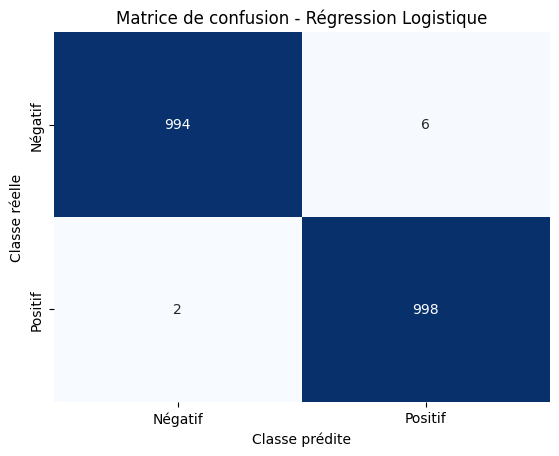

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Liste pour stocker les predictions
y_hat = []

for tweet in test_x:
    # Obtenir la prédiction pour le tweet
    y_pred = predict_tweet(tweet, freqs, theta)
    
    if y_pred > 0.5:
        # Ajouter 1.0 à la fin de la liste
        y_hat.append(float(1))
    else:
        # Ajouter 0 à la fin de la list
        y_hat.append(float(0))

# Fonction pour visualiser la matrice de confusion
def plot_confusion_matrix():
    # Matrice de confusion pour la régression logistique
    cm_logreg = confusion_matrix(test_y,y_hat)
    
    # Matrice de confusion pour la régression logistique
    ax = sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', cbar=False)
    ax.set_title('Matrice de confusion - Régression Logistique')
    ax.set_xlabel('Classe prédite')
    ax.set_ylabel('Classe réelle')
    ax.set_xticklabels(['Négatif', 'Positif'])
    ax.set_yticklabels(['Négatif', 'Positif'])
    
plot_confusion_matrix()

# Partie 5: Analyse des erreurs

Dans cette partie, vous verrez quelques tweets que votre modèle a mal classés. 

**QUESTION**:

- Quel type de tweets votre modèle classe-t-il incorrectement ?
- Pourquoi pensez-vous que les mauvaises classifications se sont produites ? Plus précisément, quel type de tweets votre modèle classe-t-il incorrectement ?

In [68]:
print('Label Predicted Tweet')
for x,y in zip(test_x,test_y):
    y_hat = predict_tweet(x, freqs, theta)

    if np.abs(y - (y_hat > 0.5)) > 0:
        print('THE TWEET IS:', x)
        print('THE PROCESSED TWEET IS:', process_tweet(x))
        print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(process_tweet(x)).encode('ascii', 'ignore')))

Label Predicted Tweet
THE TWEET IS: off to the park to get some sunlight : )
THE PROCESSED TWEET IS: ['park', 'get', 'sunlight']
1	0.49997887	b'park get sunlight'
THE TWEET IS: @msarosh Uff Itna Miss karhy thy ap :p
THE PROCESSED TWEET IS: ['uff', 'itna', 'miss', 'karhi', 'thi', 'ap', ':p']
1	0.47351101	b'uff itna miss karhi thi ap :p'
THE TWEET IS: @phenomyoutube u probs had more fun with david than me : (
THE PROCESSED TWEET IS: ['u', 'prob', 'fun', 'david']
0	0.50883101	b'u prob fun david'
THE TWEET IS: pats jay : (
THE PROCESSED TWEET IS: ['pat', 'jay']
0	0.50083903	b'pat jay'
THE TWEET IS: @bae_ts WHATEVER STIL L YOUNG &gt;:-(
THE PROCESSED TWEET IS: ['whatev', 'stil', 'l', 'young', '>:-(']
0	0.50025041	b'whatev stil l young >:-('
THE TWEET IS: my beloved grandmother : ( https://t.co/wt4oXq5xCf
THE PROCESSED TWEET IS: ['belov', 'grandmoth']
0	0.50000007	b'belov grandmoth'
THE TWEET IS: @CHEDA_KHAN Thats life. I get calls from people I havent seen in 20 years and its always favours

/var/folders/xp/glrbnn6n3fj9h1_rpn0wgjzw0000gn/T/ipykernel_89218/3590713043.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(process_tweet(x)).encode('ascii', 'ignore')))


In [69]:
# Fonction pour analyser les tweets mal classifiés
def analyze_misclassified_tweets(test_x, test_y, freqs, theta):
    misclassified = []
    probabilities = []
    
    for i, (x, y) in enumerate(zip(test_x, test_y)):
        # Ensure y_hat is a NumPy array
        y_hat = np.array(predict_tweet(x, freqs, theta))
        y_hat_value = float(y_hat[0][0])
        predicted_class = 1 if y_hat_value > 0.5 else 0
        
        # Collecter toutes les probabilités pour l'analyse de distribution
        probabilities.append({
            'index': i,
            'tweet': x,
            'true_label': int(y[0]),
            'predicted_prob': y_hat_value,
            'distance_from_threshold': abs(0.5 - y_hat_value)
        })
        
        if predicted_class != y[0]:
            processed_tweet = process_tweet(x)
            misclassified.append({
                'index': i,
                'tweet': x,
                'processed_tweet': processed_tweet,
                'true_label': int(y[0]),
                'predicted_prob': y_hat_value,
                'predicted_class': predicted_class,
                'distance_from_threshold': abs(0.5 - y_hat_value),
                'tweet_length': len(processed_tweet),
                'has_emoji': any(emoji in x for emoji in [':)', ':(', ':D', ':P', ':-)', ':-(', ';)', ';-)']),
                'positive_score': float(extract_features(x, freqs)[0, 1]),
                'negative_score': float(extract_features(x, freqs)[0, 2]),
                'score_difference': abs(float(extract_features(x, freqs)[0, 1]) - float(extract_features(x, freqs)[0, 2]))
            })
    
    return misclassified, probabilities

# Analyser les tweets mal classifiés
misclassified, probabilities = analyze_misclassified_tweets(test_x, test_y, freqs, theta)
misclassified

[{'index': 753,
  'tweet': 'off to the park to get some sunlight : )',
  'processed_tweet': ['park', 'get', 'sunlight'],
  'true_label': 1,
  'predicted_prob': 0.49997886569331385,
  'predicted_class': 0,
  'distance_from_threshold': 2.113430668615468e-05,
  'tweet_length': 3,
  'has_emoji': False,
  'positive_score': 166.0,
  'negative_score': 187.0,
  'score_difference': 21.0},
 {'index': 822,
  'tweet': '@msarosh Uff Itna Miss karhy thy ap :p',
  'processed_tweet': ['uff', 'itna', 'miss', 'karhi', 'thi', 'ap', ':p'],
  'true_label': 1,
  'predicted_prob': 0.47351101033468695,
  'predicted_class': 0,
  'distance_from_threshold': 0.026488989665313045,
  'tweet_length': 7,
  'has_emoji': False,
  'positive_score': 121.0,
  'negative_score': 243.0,
  'score_difference': 122.0},
 {'index': 1298,
  'tweet': '@phenomyoutube u probs had more fun with david than me : (',
  'processed_tweet': ['u', 'prob', 'fun', 'david'],
  'true_label': 0,
  'predicted_prob': 0.5088310148088957,
  'predicte

In [70]:
# Fonction pour analyser les caractéristiques des tweets mal classifiés
def analyze_misclassification_patterns(misclassified):
    # Convertir en DataFrame pour faciliter l'analyse
    df = pd.DataFrame(misclassified)

    # Statistiques générales
    total_misclassified = len(misclassified)
    false_positives = df[df['true_label'] == 0].shape[0]
    false_negatives = df[df['true_label'] == 1].shape[0]
    
    # Analyse des caractéristiques
    avg_distance = df['distance_from_threshold'].mean()
    avg_tweet_length = df['tweet_length'].mean()
    emoji_percentage = df['has_emoji'].mean() * 100
    
    # Mots les plus fréquents dans les tweets mal classifiés
    all_words = []
    for tweet in df['processed_tweet']:
        all_words.extend(tweet)
    
    word_freq = {}
    for word in all_words:
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1
    
    common_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]
    
    # Analyse des scores
    avg_pos_score = df['positive_score'].mean()
    avg_neg_score = df['negative_score'].mean()
    avg_score_diff = df['score_difference'].mean()
    
    # Résultats
    results = {
        'total_misclassified': total_misclassified,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'avg_distance_from_threshold': avg_distance,
        'avg_tweet_length': avg_tweet_length,
        'emoji_percentage': emoji_percentage,
        'common_words': common_words,
        'avg_positive_score': avg_pos_score,
        'avg_negative_score': avg_neg_score,
        'avg_score_difference': avg_score_diff
    }
    
    return results, df

# Analyser les motifs de mauvaise classification
misclassification_results, misclassified_df = analyze_misclassification_patterns(misclassified)
misclassification_results

{'total_misclassified': 8,
 'false_positives': 6,
 'false_negatives': 2,
 'avg_distance_from_threshold': np.float64(0.00794216827012529),
 'avg_tweet_length': np.float64(5.75),
 'emoji_percentage': np.float64(25.0),
 'common_words': [('get', 2),
  ('park', 1),
  ('sunlight', 1),
  ('uff', 1),
  ('itna', 1),
  ('miss', 1),
  ('karhi', 1),
  ('thi', 1),
  ('ap', 1),
  (':p', 1),
  ('u', 1),
  ('prob', 1),
  ('fun', 1),
  ('david', 1),
  ('pat', 1),
  ('jay', 1),
  ('whatev', 1),
  ('stil', 1),
  ('l', 1),
  ('young', 1)],
 'avg_positive_score': np.float64(198.75),
 'avg_negative_score': np.float64(218.5),
 'avg_score_difference': np.float64(25.25)}

In [71]:
# Fonction pour analyser la distribution des probabilités
def analyze_probability_distribution(probabilities):
    df = pd.DataFrame(probabilities)
    
    # Séparer les tweets positifs et négatifs
    pos_probs = df[df['true_label'] == 1]['predicted_prob']
    neg_probs = df[df['true_label'] == 0]['predicted_prob']
    
    # Calculer les statistiques
    pos_mean = pos_probs.mean()
    #pos_median = pos_probs.median()
    #pos_std = pos_probs.std()
    
    neg_mean = neg_probs.mean()
    #neg_median = neg_probs.median()
    #neg_std = neg_probs.std()
    
    # Calculer le nombre de tweets proches du seuil
    close_threshold = 0.1  # Considérer les tweets avec une probabilité à ±0.1 du seuil
    pos_close = pos_probs[(pos_probs > 0.5 - close_threshold) & (pos_probs < 0.5 + close_threshold)].count()
    neg_close = neg_probs[(neg_probs > 0.5 - close_threshold) & (neg_probs < 0.5 + close_threshold)].count()
    
    # Pourcentage de tweets proches du seuil
    pos_close_percent = (pos_close / len(pos_probs)) * 100
    neg_close_percent = (neg_close / len(neg_probs)) * 100
    
    results = {
        'positive_tweets': {
            'count': len(pos_probs),
            'mean_prob': pos_mean,
            #'median_prob': pos_median,
            #'std_dev': pos_std,
            'close_to_threshold_count': pos_close,
            'close_to_threshold_percent': pos_close_percent
        },
        'negative_tweets': {
            'count': len(neg_probs),
            'mean_prob': neg_mean,
            #'median_prob': neg_median,
            #'std_dev': neg_std,
            'close_to_threshold_count': neg_close,
            'close_to_threshold_percent': neg_close_percent
        }
    }
    
    return results, df

# Analyser la distribution des probabilités
probability_results, probability_df = analyze_probability_distribution(probabilities)
    

In [72]:
probability_results

{'positive_tweets': {'count': 1000,
  'mean_prob': np.float64(0.8634593864397707),
  'close_to_threshold_count': np.int64(60),
  'close_to_threshold_percent': np.float64(6.0)},
 'negative_tweets': {'count': 1000,
  'mean_prob': np.float64(0.07091898921834003),
  'close_to_threshold_count': np.int64(70),
  'close_to_threshold_percent': np.float64(7.000000000000001)}}

True

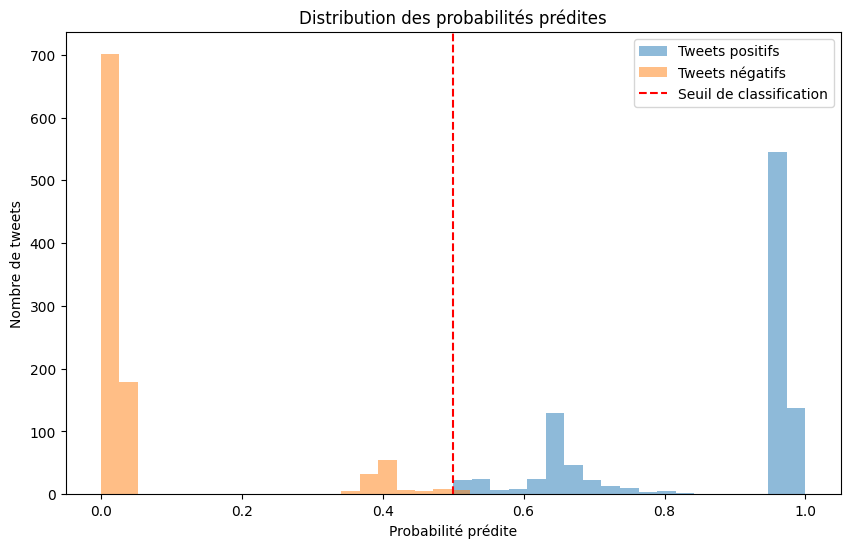

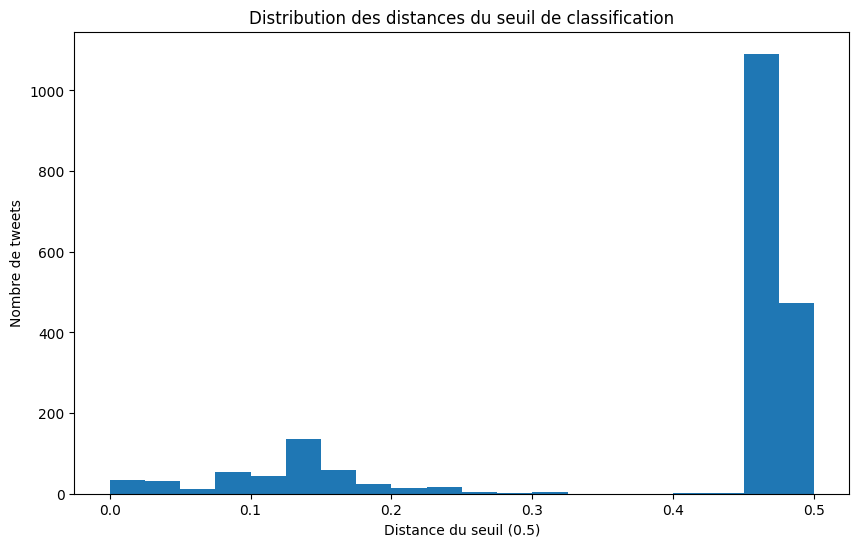

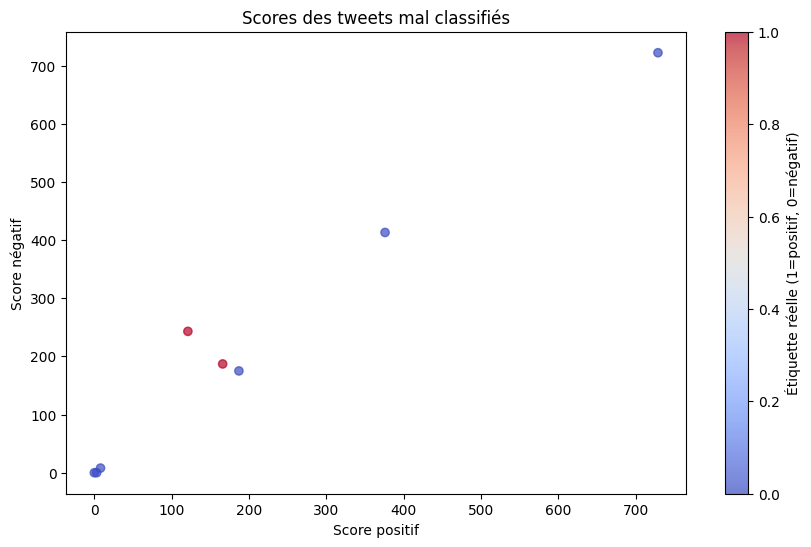

In [73]:
import matplotlib.pyplot as plt

# Fonction pour créer des visualisations
def create_visualizations(probability_df, misclassified_df):
   #os.makedirs('/home/ubuntu/analysis/figures', exist_ok=True)
    
    # Distribution des probabilités
    plt.figure(figsize=(10, 6))
    pos_probs = probability_df[probability_df['true_label'] == 1]['predicted_prob']
    neg_probs = probability_df[probability_df['true_label'] == 0]['predicted_prob']
    
    plt.hist(pos_probs, bins=20, alpha=0.5, label='Tweets positifs')
    plt.hist(neg_probs, bins=20, alpha=0.5, label='Tweets négatifs')
    plt.axvline(x=0.5, color='r', linestyle='--', label='Seuil de classification')
    plt.xlabel('Probabilité prédite')
    plt.ylabel('Nombre de tweets')
    plt.title('Distribution des probabilités prédites')
    plt.legend()
    #plt.savefig('/home/ubuntu/analysis/figures/probability_distribution.png')
    
    # Distance du seuil
    plt.figure(figsize=(10, 6))
    plt.hist(probability_df['distance_from_threshold'], bins=20)
    plt.xlabel('Distance du seuil (0.5)')
    plt.ylabel('Nombre de tweets')
    plt.title('Distribution des distances du seuil de classification')
    #plt.savefig('/home/ubuntu/analysis/figures/threshold_distance.png')
    
    # Tweets mal classifiés
    if len(misclassified_df) > 0:
        plt.figure(figsize=(10, 6))
        plt.scatter(misclassified_df['positive_score'], misclassified_df['negative_score'], 
                   c=misclassified_df['true_label'], cmap='coolwarm', alpha=0.7)
        plt.xlabel('Score positif')
        plt.ylabel('Score négatif')
        plt.title('Scores des tweets mal classifiés')
        plt.colorbar(label='Étiquette réelle (1=positif, 0=négatif)')
        #plt.savefig('/home/ubuntu/analysis/figures/misclassified_scores.png')
    
    return True

# Créer des visualisations
create_visualizations(probability_df, misclassified_df)
    

# Partie 6: Prediction avec votre propre tweet

In [74]:
# Changez le tweet pour tester
my_tweet = 'Absolutely loved the movie! It was so entertaining and had a great cast.'

print(process_tweet(my_tweet))
y_hat = predict_tweet(my_tweet, freqs, theta)
print(y_hat)
if y_hat > 0.5:
    print('Positive sentiment')
else: 
    print('Negative sentiment')

['absolut', 'love', 'movi', 'entertain', 'great', 'cast']
[[0.59554589]]
Positive sentiment
